
# Paraschiv Initial Contact Detection

This example can be referenced by citing the package.

The example illustrates how the Paraschiv initial contact detection algorithm is used to detect initial contacts using body acceleration recorded with a triaxial accelerometer worn or fixed on the lower back. The initial contact detection algorithm is implemented in the main module [`ngmt.modules.icd._paraschiv`](https://github.com/neurogeriatricskiel/NGMT/tree/main/ngmt/modules/icd/_paraschiv.py).

The algorithm takes accelerometer data as input, specifically the vertical acceleration component, and processes each specified gait sequence independently. The algorithm requires the start and duration of each gait sequence, in the format provided by the Gait Sequence detection algorithm ([`ngmt.modules.gsd._paraschiv`](https://github.com/neurogeriatricskiel/NGMT/tree/main/ngmt/modules/gsd/_paraschiv.py)). Gait sequences information are provided as a Dataframe which consists of the onset and duration of the gait sequences. The sampling frequency of the accelerometer data is also required as another input.

For each gait sequence, the algorithm applies the Signal Decomposition Algorithm for Initial Contacts (ICs). The algorithm handles multiple gait sequences and ensures uniform output by padding the initial contacts lists with NaN values to match the length of the sequence with the maximum number of initial contacts detected among all sequences. The final processed output is a Dataframe which includes onset, event_type, tracking_systems and tracked_points.

Additionally, the algorithm provides an option to plot the results. The processed acceleration signal, along with the detected initial contacts, is visualized for each gait sequence.

## Import libraries
The necessary libraries such as numpy, matplotlib.pyplot, dataset (mobilised), gait sequence detection, and initial contact detection classes are imported from their corresponding modules. Make sure that you have all the required libraries and modules installed before running this code. You also may need to install the 'ngmt' library and its dependencies if you haven't already.

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from ngmt.datasets import mobilised
from ngmt.modules.gsd import ParaschivIonescuGaitSequenceDetection
from ngmt.modules.icd import ParaschivIonescuInitialContactDetection
from ngmt.config import cfg_colors

## Data Preparation

To implement the initial contact algorithm, we load example data from a congestive heart failure (CHF) cohort, which is publicly available on the Zenodo repository [![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.7547125.svg)](https://doi.org/10.5281/zenodo.7547125). 

The participant was assessed for 2.5 hours in the real-world while doing different daily life activities and also was asked to perform specific tasks such as outdoor walking, walking up and down a slope and stairs and moving from one room to another [`1`].

Since we will use norm of the accleration signal to detect gait sequences, we don't need to take care of orientation of the signal.

Refertences

.. [`1`] Mazzà, Claudia, et al. "Technical validation of real-world monitoring of gait: a multicentric observational study." BMJ open 11.12 (2021): e050785. http://dx.doi.org/10.1136/bmjopen-2021-050785


In [9]:
# The 'file_path' variable holds the absolute path to the data file
file_path = (
    r"C:\Users\Project\Desktop\Gait_Sequence\Mobilise-D dataset_1-18-2023\CHF\data.mat"
)

# In this example, we use "SU" as tracking_system and "LowerBack" as tracked points.
tracking_sys = "SU"
tracked_points = {tracking_sys: ["LowerBack"]}

# The 'mobilised.load_recording' function is used to load the data from the specified file_path
recording = mobilised.load_recording(
    file_name=file_path, tracking_systems=[tracking_sys], tracked_points=tracked_points
)

# Load lower back acceleration data
acceleration_data = recording.data[tracking_sys][
    ["LowerBack_ACCEL_x", "LowerBack_ACCEL_y", "LowerBack_ACCEL_z"]
]

# Get the corresponding sampling frequency
sampling_frequency = recording.channels[tracking_sys][
    recording.channels[tracking_sys]["name"] == "LowerBack_ACCEL_x"
]["sampling_frequency"].values[0]

## Visualisation of the Data
The raw acceleration data including components of x, y and z axis is represented.

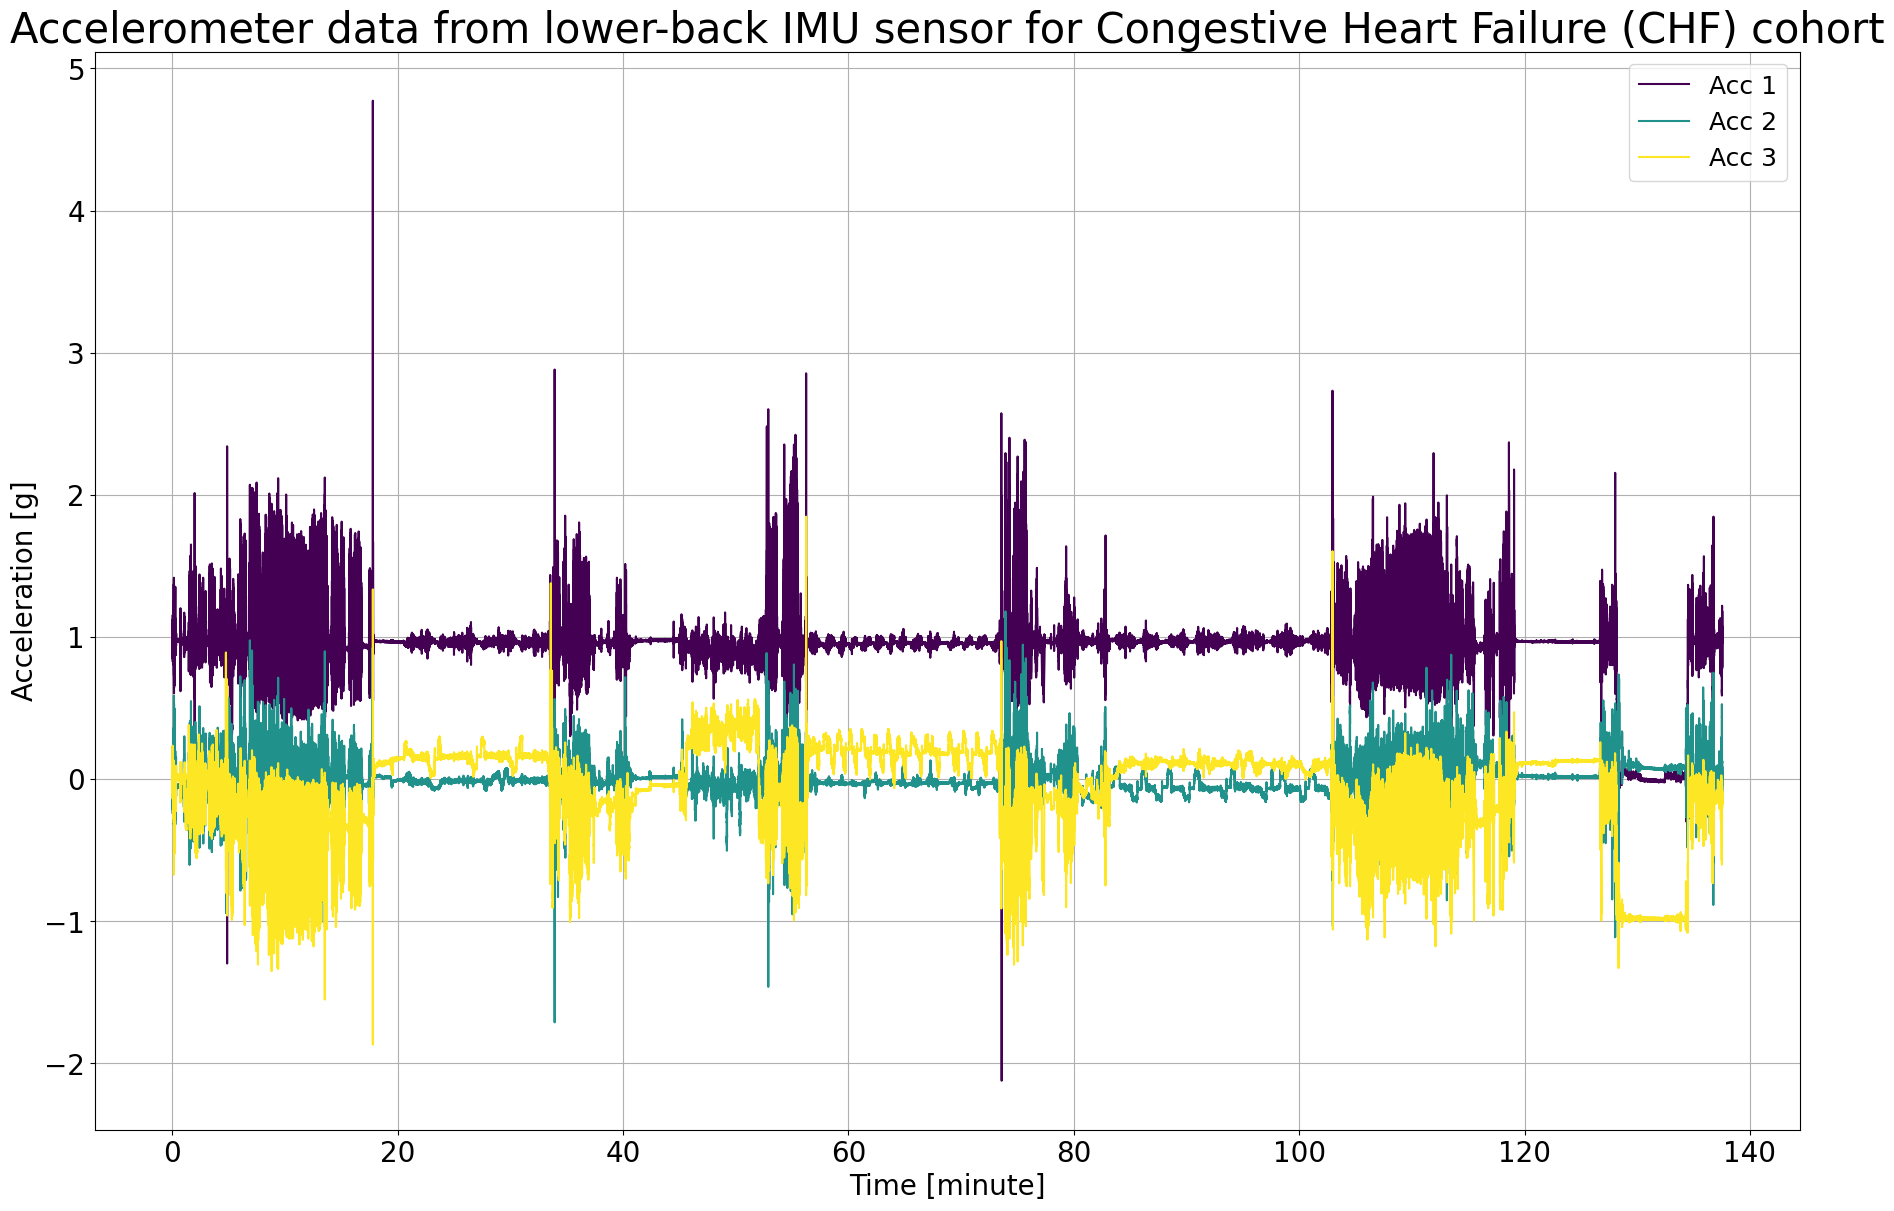

In [10]:
# Calculate the time values in minutes
# The 'time_in_minute' array represents time values in minutes, computed based on the length of 'acceleration_data' and 'sampling_frequency'.
time_in_minute = np.arange(len(acceleration_data)) / (60 * sampling_frequency)

# Create a figure with a specified size
plt.figure(figsize=(22, 14))

# Get colors for raw
colors = cfg_colors["raw"]

# A loop is used to plot data for each accelerometer axis, applying different colors from the color map.
for i in range(3):
    plt.plot(
        time_in_minute,
        acceleration_data[f"LowerBack_ACCEL_{chr(120 + i)}"],
        color=colors[i],
        label=f"Acc {i + 1}",
    )

# Add labels and legends
plt.xlabel("Time [minute]", fontsize=20)
plt.ylabel("Acceleration [g]", fontsize=20)
plt.legend(fontsize=18)

# Add a title with a specified font size
plt.title(
    "Accelerometer data from lower-back IMU sensor for Congestive Heart Failure (CHF) cohort",
    fontsize=30,
)

# Customize tick font sizes
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Display a grid for reference
plt.grid(visible=None, which="both", axis="both")

# Show the plot
plt.show()

Let's zoom in on specific time periods in the data, particularly the first 10 seconds, where clear blinks are evident.

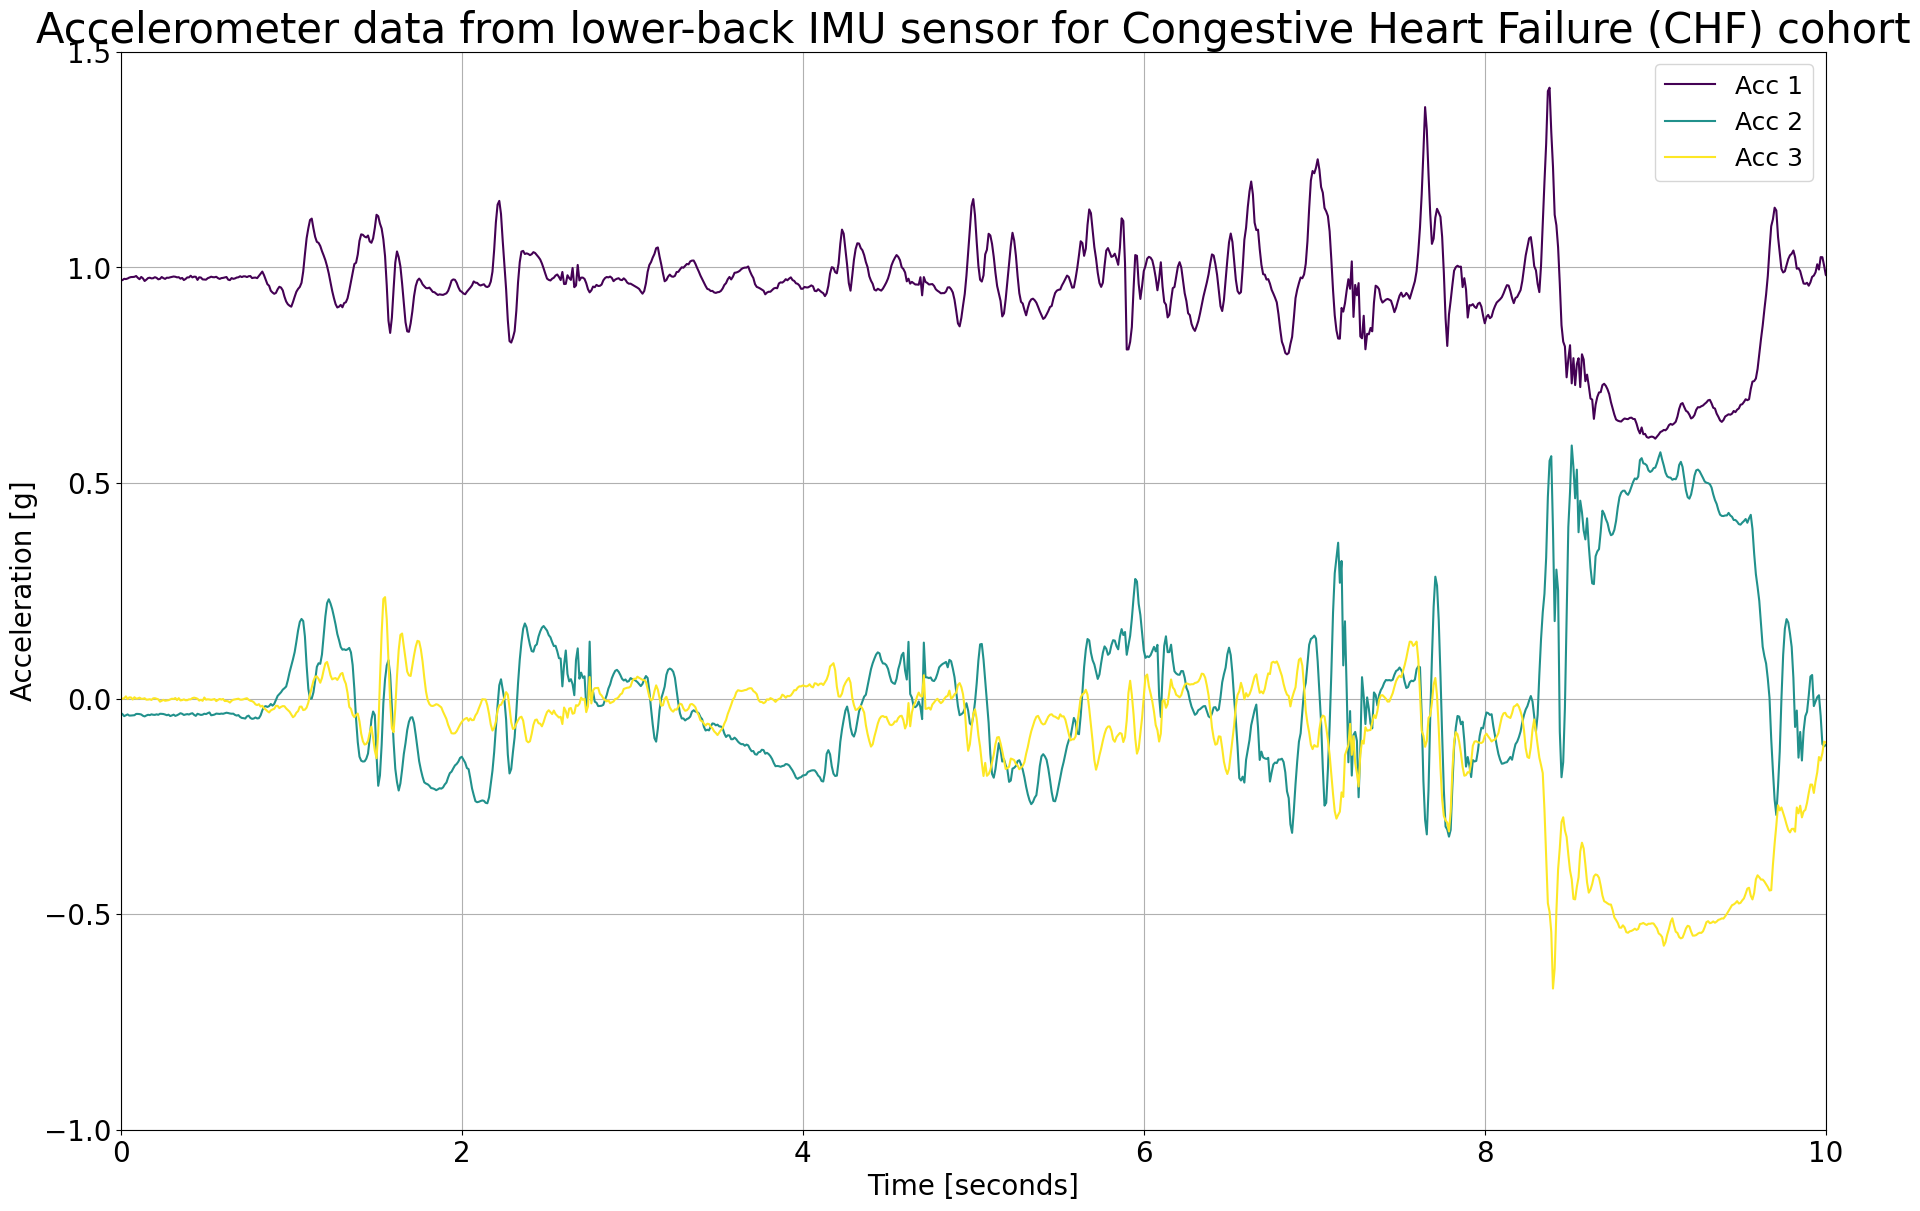

In [11]:
# Calculate the time values based on the length of the data
num_samples = len(acceleration_data)
time_seconds = np.arange(num_samples) / sampling_frequency

# Create a figure with the specified size
plt.figure(figsize=(22, 14))

# Plot acceleration data for each axis with time on the x-axis
for i in range(3):
    plt.plot(
        time_seconds,
        acceleration_data[f"LowerBack_ACCEL_{chr(120 + i)}"],
        color=colors[i],
        label=f"Acc {i + 1}",
    )

# Add labels and legends
plt.xlabel("Time [seconds]", fontsize=20)
plt.ylabel("Acceleration [g]", fontsize=20)
plt.legend(fontsize=18)

# Add a title
plt.title(
    "Accelerometer data from lower-back IMU sensor for Congestive Heart Failure (CHF) cohort",
    fontsize=30,
)

# Customize font sizes
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Set x-axis and y-axis limits for a specific duration (in seconds) and acceleration range
plt.xlim(0, 10)
plt.ylim(-1, 1.5)

# Display a grid for reference
plt.grid(visible=None, which="both", axis="both")

# Show the plot
plt.show()

## Applying Paraschiv initial contact detection algorithm
Now, we are running Paraschiv initial contact detection algorithm from icd module [`NGMT.ngmt.modules.icd._paraschiv.ParaschivIonescuInitialContactDetection`](https://github.com/neurogeriatricskiel/NGMT/tree/main/ngmt/modules/icd/_paraschiv.py) to detect initial contacts throughout the detected gait sequences. The first inputs is acceleration data which consist of accelerometer data (N, 3) for the x, y, and z axes. The second input is gait sequences which was detected by Paraschiv gait sequence detection (). They were detected using gait sequence detection algorithm using [`NGMT.ngmt.modules.gsd._paraschiv.ParaschivIonescuGaitSequenceDetection`](https://github.com/neurogeriatricskiel/NGMT/tree/main/ngmt/modules/gsd/_paraschiv.p). The other inputs of the function are the initial sampling frequency of the accelerometer data and a plot option. Optionally, if the plot_results flag is set to True, a visualization plot is generated to display the preprocessed data and the detected initial contacts.

In [12]:
# The results of the gait sequence detection algorithm is used to detect initial contacts.
# Consequently, before running initial contact detection algorithm, the gait sequence detetction algorithm have to be runned on acceleretion signal.
# Create an instance of the ParaschivIonescuGaitSequenceDetection class
gsd = ParaschivIonescuGaitSequenceDetection(target_sampling_freq_Hz=40)

# Call the gait sequence detection using gsd.detect
gsd = gsd.detect(
    data=acceleration_data, sampling_freq_Hz=sampling_frequency, plot_results=False
)

# Gait sequences are stored in gait_sequences_ attribute of gsd
gait_sequences = gsd.gait_sequences_

# Add events to the recording as a dictionary including tracking system and events
gait_sequence_events = gait_sequences
recording.add_events(tracking_system = tracking_sys, new_events= gait_sequence_events)

# Now, use ParaschivIonescu Initial_Contact_Detection to detect initial contacts within detected gait sequences.
icd = ParaschivIonescuInitialContactDetection(target_sampling_freq_Hz=40)

# Call the initial contact detection using icd.detect
icd = icd.detect(
    data=acceleration_data, gait_sequences = gait_sequences, sampling_freq_Hz=sampling_frequency, plot_results=False
)

# Initial contacts are stored in initial_contacts_ attribute of icd
initial_contacts = icd.initial_contacts_

# Add events to the recording as a dictionary including tracking system and events
initial_contacts_events = initial_contacts
recording.add_events(tracking_system = tracking_sys, new_events = initial_contacts_events)

# Show events types including detected gait sequences and initial contacts
print(recording.events)

86 gait sequence(s) detected.
{'SU':          onset  duration       event_type tracking_systems tracked_points
0        4.500      5.25    gait sequence               SU      LowerBack
1       90.225     10.30    gait sequence               SU      LowerBack
2      106.075      5.60    gait sequence               SU      LowerBack
3      116.225     10.35    gait sequence               SU      LowerBack
4      141.275      5.85    gait sequence               SU      LowerBack
...        ...       ...              ...              ...            ...
3533  8203.200       NaN  initial contact               SU      LowerBack
3534  8203.675       NaN  initial contact               SU      LowerBack
3535  8204.325       NaN  initial contact               SU      LowerBack
3536  8205.425       NaN  initial contact               SU      LowerBack
3537  8206.100       NaN  initial contact               SU      LowerBack

[3538 rows x 5 columns]}


To better understand the concept of the detected initial contacts, let’s take a closer look at the raw acceleration data. Let's zoom in on specific time periods in the raw acceleration data, particularly the first detected gait sequence and its corresponding initial contacts. 

To get a better understanding of the results, the raw acceleration data, detected first gait sequence and its corresponding initial contacts are plotted. The green and red vertical lines show the start and end of the first gait sequence. The vertical blue line are representing detected initial contacts within the first gait sequence.

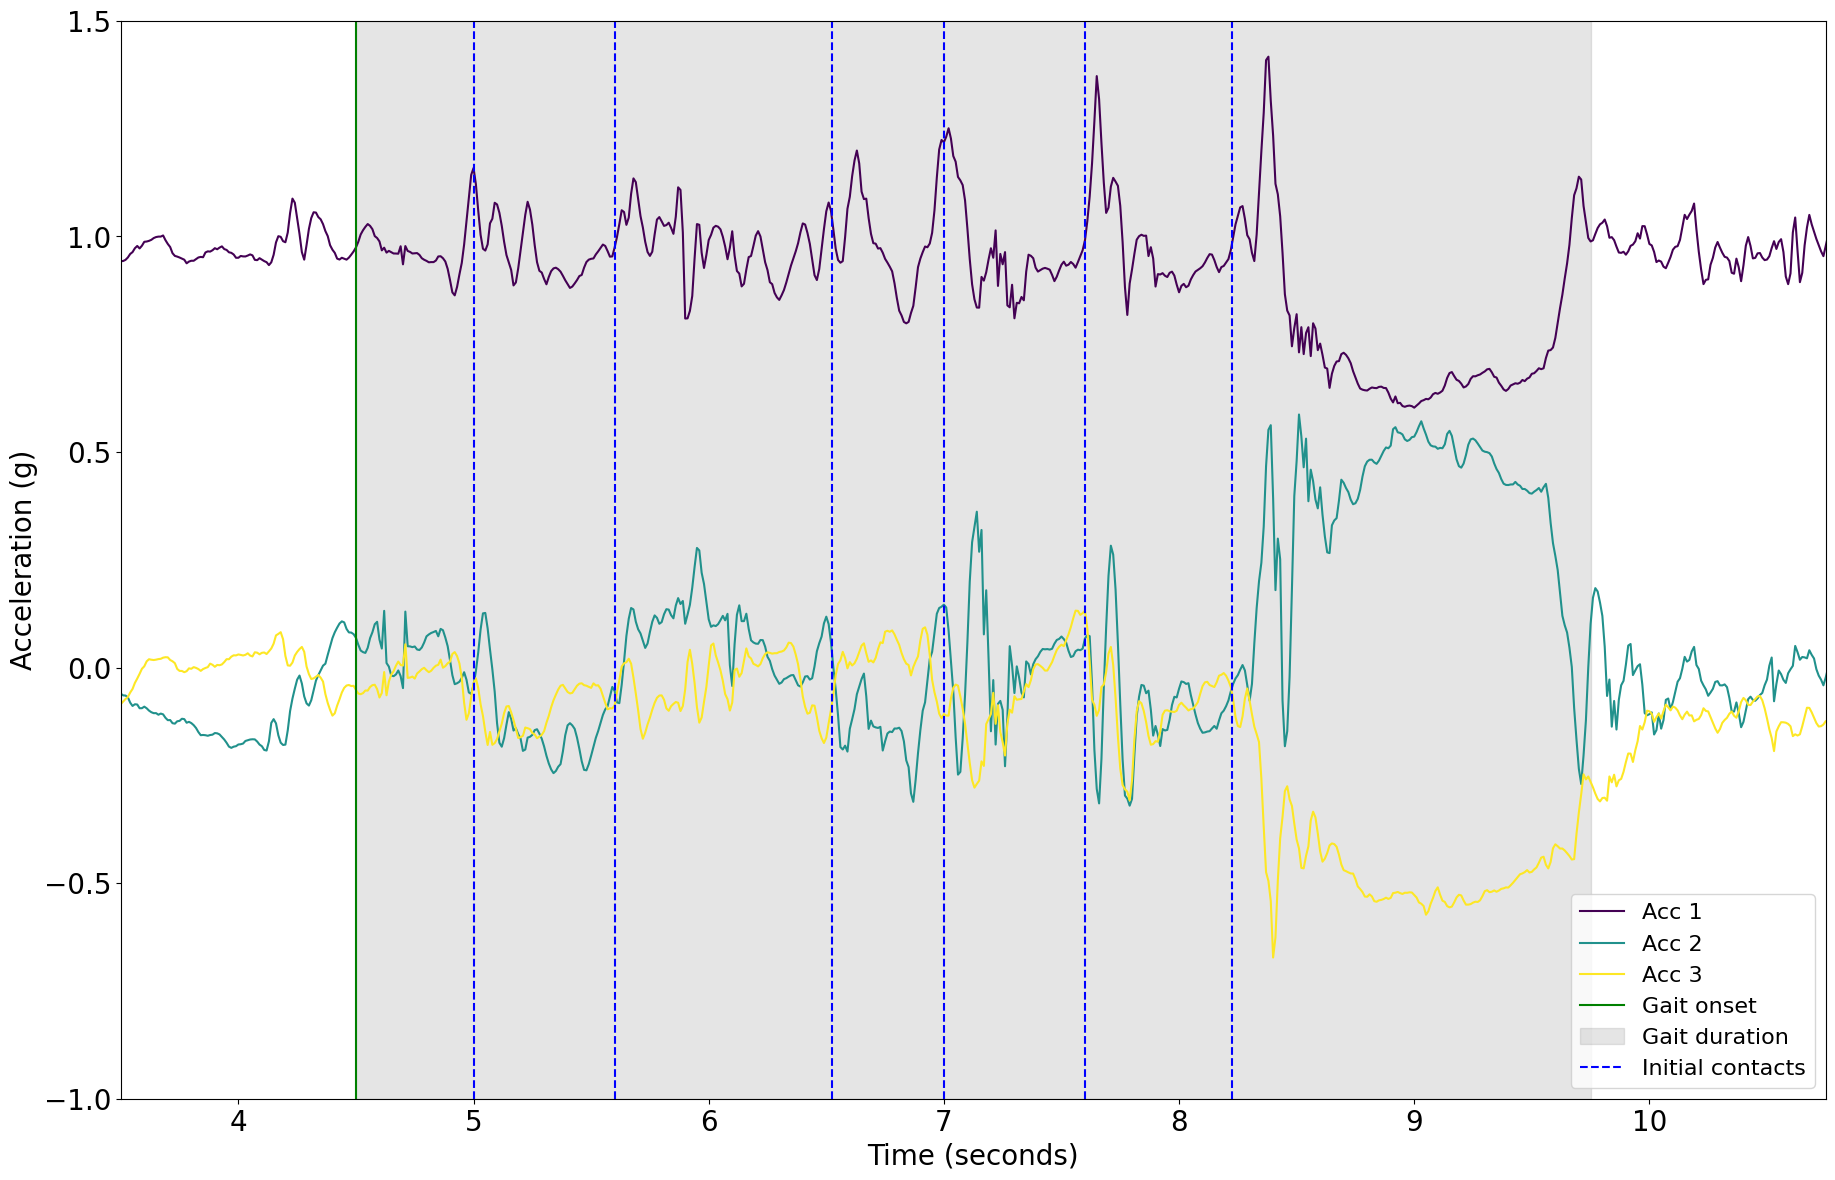

In [13]:
# Access the first detected gait sequence
first_gait_sequence = recording.events[tracking_sys][recording.events[tracking_sys]['event_type'] == 'gait sequence'].iloc[0]

# Plot the raw data from the lower back
fig, ax = plt.subplots(figsize=(22, 14))

# Plot the acceleration data
for i in range(3):
    ax.plot(
        time_seconds,
        acceleration_data[f"LowerBack_ACCEL_{chr(120 + i)}"],
        color=colors[i],
        label=f"Acc {i + 1}",
    )

# Plot the first element of gait sequences if they exist
plt.axvline(first_gait_sequence["onset"], color="g", label="Gait onset")
ax.axvspan(
    first_gait_sequence["onset"],
    first_gait_sequence["onset"] + first_gait_sequence["duration"],
    alpha=0.2,
    color="gray",
    label="Gait duration",
)

# Plot the initial contacts for the first gait sequence
for ic_time in initial_contacts_events[initial_contacts_events["onset"].between(
    first_gait_sequence["onset"], first_gait_sequence["onset"] + first_gait_sequence["duration"]
)]["onset"]:
    ax.axvline(ic_time, color="blue", linestyle="--")

# Customize plot
start_limit = first_gait_sequence["onset"] - 1
end_limit = first_gait_sequence["onset"] + first_gait_sequence["duration"] + 1
ax.set_xlim(start_limit, end_limit)
ax.set_ylim(-1, 1.5)
ax.set_xlabel("Time (seconds)", fontsize=20)
ax.set_ylabel("Acceleration (g)", fontsize=20)
ax.legend(loc="upper right", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Add legend for "Initial Contact" outside the loop
ax.legend(["Acc 1", "Acc 2", "Acc 3", "Gait onset", "Gait duration", "Initial contacts"], fontsize=16, loc="best",)

plt.show()
